# Pulling Stock Data
This is a Python notebook to get Stock data based on ticker symbols.

That data can then be used for a D3 visualization like: https://bl.ocks.org/mbostock/1256572

## 0. Programming in Python
Let's start by seeing how to make variables, functions, and logic in Python.

### Variables
Variables can take on many data types, from `'Strings'` to numbers (`0`), `True`/`False` and even functions.

Type `x = 'Hello world!'` in the box below, then press `Shift + Enter` to execute the code.

Nothing happened... That's because we've only just created the variable `x`. Now to show the value of the variable, we need to type `x`. Again, press `Shift + Enter` to execute the code.

### Functions
Functions can take on any name - you get to choose - but the syntax for defining a function is always the same. Functions can also operate on one or more `variable` that gets defined when you initially create the function. These variables are a placeholder for what to do with any data that gets sent to the function when it is used.
- First, define the name of the function with `def nameOfFunction():`
- Then, if you want to send a variable to the function, put that variable name between the ().
- Lastly, on the next line, tab in one tab, and write the instructions for what the function will do.

Below, type `def myFunction(y):` on the first line, then tab in and type `return y + 3`.  Press `Shift + Enter` to save that functions.

In the box below that, type `myFunction(3)` - what do you expect it to return when you press `Shift + Enter`?

### Logic
Logic is the last piece of the programming foundation; this will test some comparison, and depending on whether the comparison is `True` or `False`, one outcome will result.

We've put the basic structure in the box below, but you need to add a comparison in the `()` to test: e.g. `(5 > 3)` or `('a' == 'a')`. Press `Shift + Enter` to run the logic below.

In [ ]:
if ():
   print 'The comparison is True'
else:
   print 'The comparison is False'

### Wrap Up
So that's it!  Variables, functions, and logic are the building blocks of programming in any language.

Now that you've got a handle on those, we're going to get a bit more complicated working with our data.

*Note: Just like above, you'll need to press `Shift + Enter` to run any code in an `In [ ]:` box.*

## 1. Sourcing Data
To begin working with our data, let's use an API called [Quandl](https://www.quandl.com) to bring in stock data.

We need to first `import quandl` to get the Quandl library of functions, then set our API key. The key for today is `Byjzu4U8rmR1iEhZnp7V` - copy and paste that between the `""` below.

In [1]:
import quandl
quandl.ApiConfig.api_key = "Byjzu4U8rmR1iEhZnp7V"

Now that we've got our connection to quandl, let's pull a single stock (`AAPL`) and store that in a variable called `data`.

Add `WIKI/AAPL` between the `""` below.

In [2]:
data = quandl.get("WIKI/AAPL", rows=5)

To find out the type of data, we can type `print type(data)`.

In [3]:
print type(data)

<class 'pandas.core.frame.DataFrame'>


And if we want to look at the data itself, we can write `data` below.

In [4]:
data

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2017-09-07,162.09,162.24,160.36,161.26,21722995.0,0.0,1.0,162.09,162.24,160.36,161.26,21722995.0
2017-09-08,160.86,161.15,158.53,158.63,28183159.0,0.0,1.0,160.86,161.15,158.53,158.63,28183159.0
2017-09-11,160.50,162.05,159.89,161.50,31028926.0,0.0,1.0,160.50,162.05,159.89,161.50,31028926.0
2017-09-12,162.61,163.96,158.77,160.82,71139119.0,0.0,1.0,162.61,163.96,158.77,160.82,71139119.0
2017-09-13,159.87,159.96,157.91,159.65,44393752.0,0.0,1.0,159.87,159.96,157.91,159.65,44393752.0


To assess the health of each stock, let's find the `Close` price for each stock. If you notice above, that's the 4th column.

Based on Quandl's [API documentation](https://docs.quandl.com/docs/time-series-2), we can extract just that column by adding `.4` after `WIKI/AAPL` to get `WIKI/AAPL.4`:

In [5]:
data = quandl.get("WIKI/AAPL.4", rows=5, collapse='monthly')
data

,Close
Date,
1980-12-31,34.13
1981-01-31,28.25
1981-02-28,26.50
1981-03-31,24.50
1981-04-30,28.38


That's great! But now we want to show data for the last 10 years.

First, we need to have Python tell us what today's date is. We've written most of this for you, but you need to add a line to output the value of `start_date`.

In [7]:
import datetime
start_date = (datetime.datetime.now() - datetime.timedelta(days=10*365)).strftime('%Y-%m-01')
start_date

'2007-09-01'

Now we need to add a new parameter to our Quandl get request. After `collapse='monthly'`, add a comma and then `start_date=start_date` inside the parenthesis.

Then, to save space in the notebook, we're only going to show the top five rows of data using `data.head(5)`.

How could you show the top 10 rows instead?

In [11]:
data = quandl.get("WIKI/AAPL.4", start_date=start_date, rows=120, collapse='monthly')
data.head(10)

,Close
Date,
2007-09-30,153.47
2007-10-31,189.95
2007-11-30,182.22
2007-12-31,198.08
2008-01-31,135.36
2008-02-29,125.02
2008-03-31,143.50
2008-04-30,173.95
2008-05-31,188.75


Python comes with a number of great visualization tools built in.

Let's do a quick visualization of the data to see if it looks right:

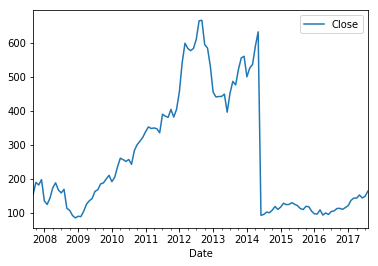

In [12]:
%matplotlib inline
ax = data.plot()

Uh-oh! Looks like there's a problem: There's a big drop in AAPL stock in 2014!

Why?!  Well, a quick Google shows they [split their stock](https://www.washingtonpost.com/news/the-switch/wp/2014/06/09/apples-stock-price-just-dropped-more-than-500-a-share-but-dont-panic/). 

Luckily, Quandl has accounted for that. Instead of `Close`, we'll need to use the `Adjusted Close` price (column 11) from Quandl.

Modify the code below to get the 11th column instead of the 4th.

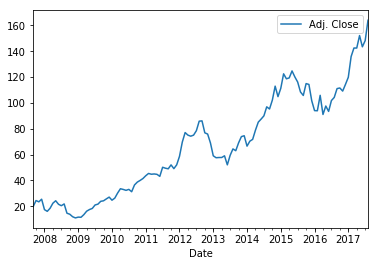

In [13]:
data = quandl.get("WIKI/AAPL.11", rows=120, collapse='monthly', start_date=start_date)
ax = data.plot()

Great! Let's get it ready for D3.js

## 2. Scrubbing Data

Based on the [D3.js show reel](https://bl.ocks.org/mbostock/1256572), we need the data to be arranged like this:

```
symbol,date,price
MSFT,Jan 2000,39.81
MSFT,Feb 2000,36.35
MSFT,Mar 2000,43.22
MSFT,Apr 2000,28.37
MSFT,May 2000,25.45```

Let's choose a few symbols from the list of Warren's companies and pull the data we need.

First, we need to bring in the cleaned CSV file we exported from Open Refine, and store it as a variable. Let's call it `buffet`.

In [1]:
from pandas import read_csv
buffet = read_csv('WB_portfolio_for_Decoded - 2017_0824.csv')
buffet

,COMPANY,TICKER,COMPANY.1,# OF SHARES,PRICE (8/24/2017),CITY,PURCHASE DATE,REGION,CEO,EMPLOYEES,WARREN COMMENT
0,Kraft Heinz,KHC,Kraft Heinz (KHC),"325,634,818",$82.80,"Chicago, IL",9/27/2005,Central,Bernard Hees (2015–),"41,000 (2017)",Without a doubt
1,Wells Fargo,WFC,Wells Fargo (WFC),"467,987,270",$52.16,"San Francisco, CA",7/7/2002,West,"Timothy J. Sloan (Oct 12, 2016–)",NaN,It is decidedly so
2,Apple Inc.,AAPL,Apple Inc. (AAPL),"130,191,960",$159.27,"Cupertino, CA",9/23/2006,West,Tim Cook,NaN,Concentrate and ask again
3,The Coca Cola Company,KO,The Coca Cola Company (KO),"400,000,000",$45.41,"Atlanta, GA",12/10/2003,Southeast,"James Quincey (May 1, 2017–)",NaN,Reply hazy try again
4,American Express Co,AXP,American Express Co (AXP),"151,610,700",$85.36,"New York City, NY",6/2/2013,Northeast,Kenneth I. Chenault (Jan 2001–),NaN,It is decidedly so
5,International Bus. Machines,IBM,International Bus. Machines (IBM),"54,084,673",$142.94,"Armonk, NY",5/7/2003,Northeast,Ginny Rometty,NaN,Reply hazy try again
6,Phillips 66,PSX,Phillips 66 (PSX),"80,689,892",$83.87,"Houston, TX",2/30/2010,South,"Greg C. Garland (Apr 30, 2012–)",NaN,Signs point to yes
7,U.S. Bancorp,USB,U.S. Bancorp (USB),"85,063,167",$51.85,"Minneapolis, MN",5/22/2004,Central,"Richard K. Davis (Dec 12, 2006–)",NaN,You may rely on it
8,CHARTER COMM-A,CHTR,CHARTER COMM-A (CHTR),"9,443,491",$389.23,"Stamford, CT",3/29/2006,Northeast,Thomas Rutledge,NaN,Reply hazy try again
9,Moody's Corp,MCO,Moody's Corp (MCO),"24,669,778",$132.20,"New York City, NY",10/4/2003,Northeast,Raymond W. McDaniel Jr.,NaN,"As I see it, yes"


Next we want to choose some of those stocks for our analysis. We could either type out the ticker symbol (e.g. `MSFT`) by hand, or we could refer to the `buffet` variable in order to select the ticker symbols. Let's choose the first 3 stocks from `buffet`. Replace `buffet[0:0]` with `buffet[0:3]`:

In [2]:
symbols = [ 'WIKI/%s.11' % ticker for ticker in buffet.TICKER[0:3] ]
symbols

['WIKI/KHC.11', 'WIKI/WFC.11', 'WIKI/AAPL.11']

We can now load in the symbol data from quandl:

In [3]:
data = quandl.get(symbols, rows=120, collapse='monthly', start_date=start_date)
data.head(5)

NameError: name 'quandl' is not defined

Let's clean up the column name to just their symbol name by removing `WIKI/` and ` - Close` from each column name.

We can iterate over the columns using the `for col in data.columns` syntax:

In [33]:
data.columns = [col.replace(' - Adj. Close','').replace('WIKI/','') for col in data.columns]
data.head(5)

,MSFT,AAPL,GE
Date,,,
2007-09-30,23.010452,19.723034,29.070548
2007-10-31,28.751349,24.411222,28.902023
2007-11-30,26.327874,23.417810,26.886746
2007-12-31,27.895009,25.456041,26.251034
2008-01-31,25.544306,17.395647,25.040101


Let's have another quick look at the data, to make sure everything looks good.

Add the code to plot the `data` (hint: you've used this code above already):

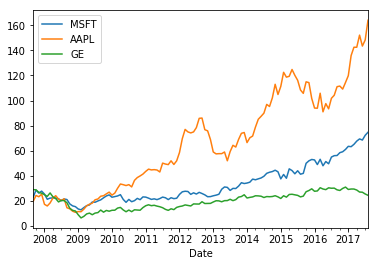

In [35]:
ax = data.plot()

## 3. Analysis

What type of analysis would be most useful for Warren?

What if we could predict the future behavior of each stock based on its past behavior?  We might be able to project stock performance forward to determine which will do well, and which might not.

To do this, we're going to use a library called `ARIMA`. [Amadeus: can you have a look into this?]

In [51]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(data.MSFT,(1,1,0))
model_fit = model.fit()
#print model_fit.summary()


                             ARIMA Model Results                              
Dep. Variable:                 D.MSFT   No. Observations:                  119
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -261.000
Method:                       css-mle   S.D. of innovations              2.169
Date:                Thu, 14 Sep 2017   AIC                            528.000
Time:                        18:01:43   BIC                            536.337
Sample:                    10-31-2007   HQIC                           531.385
                         - 08-31-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4258      0.170      2.511      0.013       0.093       0.758
ar.L1.D.MSFT    -0.1745      0.093     -1.885      0.062      -0.356       0.007
                                    Roots   

## 4. Preparing for Visualization

**TODO: Plot ARIMA Data for Warren**

Next, we want to rearrange all of the data to be more like what we need for D3. Python comes with a function called `unstack()` that does just that!

Below, make a variable called `datalist` and set it equal to `data.unstack()`.

Then show the top 10 rows of the datalist. (Hint, you've used this type of function before)

In [37]:
datalist = data.unstack()
datalist.head(10)

      Date      
MSFT  2007-09-30    23.010452
      2007-10-31    28.751349
      2007-11-30    26.327874
      2007-12-31    27.895009
      2008-01-31    25.544306
      2008-02-29    21.396187
      2008-03-31    22.324486
      2008-04-30    22.434613
      2008-05-31    22.359575
      2008-06-30    21.720053
dtype: float64

Almost there! We've done the hard work, now we just need it in a CSV format.

We've written this bit of code to clean the data a bit more and to output the data in a comma-separated value format.

In [38]:
csv = datalist.to_csv(header=True, index_label=['symbol','date','price'], date_format='%b %Y', index=True)
csv = csv.replace("price,0","price") # remove addition of ',0' on first line
print csv

symbol,date,price
MSFT,Sep 2007,23.0104518549
MSFT,Oct 2007,28.7513487027
MSFT,Nov 2007,26.3278738447
MSFT,Dec 2007,27.8950091926
MSFT,Jan 2008,25.5443061708
MSFT,Feb 2008,21.3961865799
MSFT,Mar 2008,22.324485573
MSFT,Apr 2008,22.4346134088
MSFT,May 2008,22.3595747549
MSFT,Jun 2008,21.7200530193
MSFT,Jul 2008,20.306788937
MSFT,Aug 2008,21.6331090204
MSFT,Sep 2008,21.1574818525
MSFT,Oct 2008,17.7012577657
MSFT,Nov 2008,16.1348395658
MSFT,Dec 2008,15.512427357
MSFT,Jan 2009,13.6451907307
MSFT,Feb 2009,12.9797352034
MSFT,Mar 2009,14.7639464821
MSFT,Apr 2009,16.2829371654
MSFT,May 2009,16.8967319308
MSFT,Jun 2009,19.2261999998
MSFT,Jul 2009,19.0239892299
MSFT,Aug 2009,20.0479029296
MSFT,Sep 2009,20.9181364442
MSFT,Oct 2009,22.5528741679
MSFT,Nov 2009,24.0228720785
MSFT,Dec 2009,24.896876605
MSFT,Jan 2010,23.0181752864
MSFT,Feb 2010,23.5258064045
MSFT,Mar 2010,24.0325097688
MSFT,Apr 2010,25.0561736505
MSFT,May 2010,21.2670032054
MSFT,Jun 2010,18.9671993704
MSFT,Jul 2010,21.2752462299
MSFT,A

Lastly, we want to download the file so we can bring it into our D3 visualization.

To make the downloadable file, we've got to bring in a library called `base64` which will encode the file. Then we use that to create the file and add a bit of HTML to make it so we can download the file.

In [39]:
import base64
from IPython.display import HTML

b64 = base64.b64encode(csv.encode())
payload = b64.decode()
html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{filename}</a>'
html = html.format(payload=payload,title="stocks.csv",filename="stocks.csv")
HTML(html)
